Blake Buckner - December 7th 2024

This is my MS 38 Final Project. This is a program designed to mix computer vision and image generation to make AI automatically play the game telephone with itself. 

This uses the OpenAI Models gpt4o-mini and dall-e, which means to use it you must have an OpenAI api key and some token credits for its use. This means it is not quite free to actually use but the costs are still very minimal. If desired this code could be expanded to use other fully free models but I do not have a direct way to integrate them and they are would likely be worse quality.

First we have to import all of the required libraries for the program

In [1]:
from openai import OpenAI
import matplotlib.pyplot as plt
import requests
from PIL import Image as PILImage
from io import BytesIO
import math
import imageio
from IPython.display import display, Image, clear_output
import time

Innitialize some basic variable settings to be used.

name: The base name of the image and files

detail: How detailed the image will be described

steps: How many rounds will the telephone game run for

dalle_version: Which version of dalle will be used, only integers 2 or 3

prompt: What prompt is being fed to the image description ai for what it is instructed to write when describing the image

start_url: The url for an image that will be used as the initial point to be described


In [2]:
name = "nighthawks"
detail = 50
steps = 6 # Adds roughly 10-20 seconds per step
dalle_version = 3
start_url = "https://upload.wikimedia.org/wikipedia/commons/a/a8/Nighthawks_by_Edward_Hopper_1942.jpg"

prompt = f"""   You must use a max of {detail * 3} characters. 
                You are an AI that describes images in great detail. 
                Your task is to look at the input image and provide a comprehensive description.

"""

I have to use the OpenAI api to use their service. Here I import my api key from a seprate file. If using your own you can place the api key in a txt file titled 'api-keys.txt'. or replace api_key within the client variable

In [3]:
with open('api-keys.txt', 'r') as f:
    api_keys = f.read().strip()
api_key_list = api_keys.split(',')

client = OpenAI(api_key=api_key_list[0])

Here we describe how much detail will be in our description of the image. It uses OpenAI gpt4o mini. This will be the description directly fed to the Dall-e image generation model.

In [4]:
def describe_image(prompt,url,detail=100):
  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {"type": "text", "text": prompt},
          {
            "type": "image_url",
            "image_url": {
              "url": url,
            },
          },
        ],
      }
    ],
    max_tokens=detail,
  )
  my_response = response.choices[0].message.content
  return my_response

Next we define the function to generate the image. This takes an input of the image description and generates and image in default 512x512 resolution, and returns the image url.

In [5]:
def generate_image(image_prompt,dalle=2):
  new_img = client.images.generate(
    model=f"dall-e-{dalle}", 
    prompt=image_prompt,
    n=1,
    size="512x512" if dalle == 2 else "1024x1024"
  )
  new_img_url = new_img.data[0].url
  return new_img_url


Here we begin with the actual generation. First we need the base case model instantiation so we describe and generate the first image. This essentially is just the default round one.

In [6]:
# Innitialize generation variables
all_urls = [start_url]
img_description = describe_image(prompt,start_url,detail)
all_descriptions = [img_description]
new_img_url = generate_image(img_description,dalle_version)

Now we need to just loop through for each round of telephone.
It will take a url associated with the image and describes it, then generates again.

In [7]:
# Simulate main rounds 
for i in range(steps-1):
    all_urls.append(new_img_url)
    img_description = describe_image(prompt,new_img_url,detail)
    all_descriptions.append(img_description)
    new_img_url = generate_image(img_description, dalle_version)

We take the generated descriptions from each round both save to a txt file in the descriptions folder and print them on a new line 

In [8]:
with open(f'descriptions/descriptions_{name}.txt', 'a') as file:
    # Iterate over all descriptions.
    for i in range(len(all_descriptions)):
        # Write each description followed by a newline character to the file.
        print(f'Image {i} url: {all_urls[i]}')
        print(f'Round {i}: {all_descriptions[i]} \n')
        file.write(all_descriptions[i] + '\n \n')

Image 0 url: https://upload.wikimedia.org/wikipedia/commons/a/a8/Nighthawks_by_Edward_Hopper_1942.jpg
Round 0: The scene depicts a diner at night with four patrons at the bar: two men in hats, a woman in red, and a white-suited server. 

Image 1 url: https://oaidalleapiprodscus.blob.core.windows.net/private/org-hI4klZX2t9rVqg5iqhTp7HLn/user-DTTt5Yyb5FDXt5HSvhpegNr6/img-NQh8eO73esGxIV24biSsna6h.png?st=2024-12-08T04%3A30%3A08Z&se=2024-12-08T06%3A30%3A08Z&sp=r&sv=2024-08-04&sr=b&rscd=inline&rsct=image/png&skoid=d505667d-d6c1-4a0a-bac7-5c84a87759f8&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2024-12-07T23%3A14%3A17Z&ske=2024-12-08T23%3A14%3A17Z&sks=b&skv=2024-08-04&sig=IvC3NX7wOPmy5bQCOU2uhMmKUF/jSlpERvE4NQ7qSD0%3D
Round 1: A retro diner scene with stylish patrons in hats and elegant dresses, enjoying drinks. White-suited servers attend them amid neon lights. 

Image 2 url: https://oaidalleapiprodscus.blob.core.windows.net/private/org-hI4klZX2t9rVqg5iqhTp7HLn/user-DTTt5Yyb5FDXt5HSvhpegN

To show all the images together we plot a grid of each image in left to right top to bottom order for when they were generated.

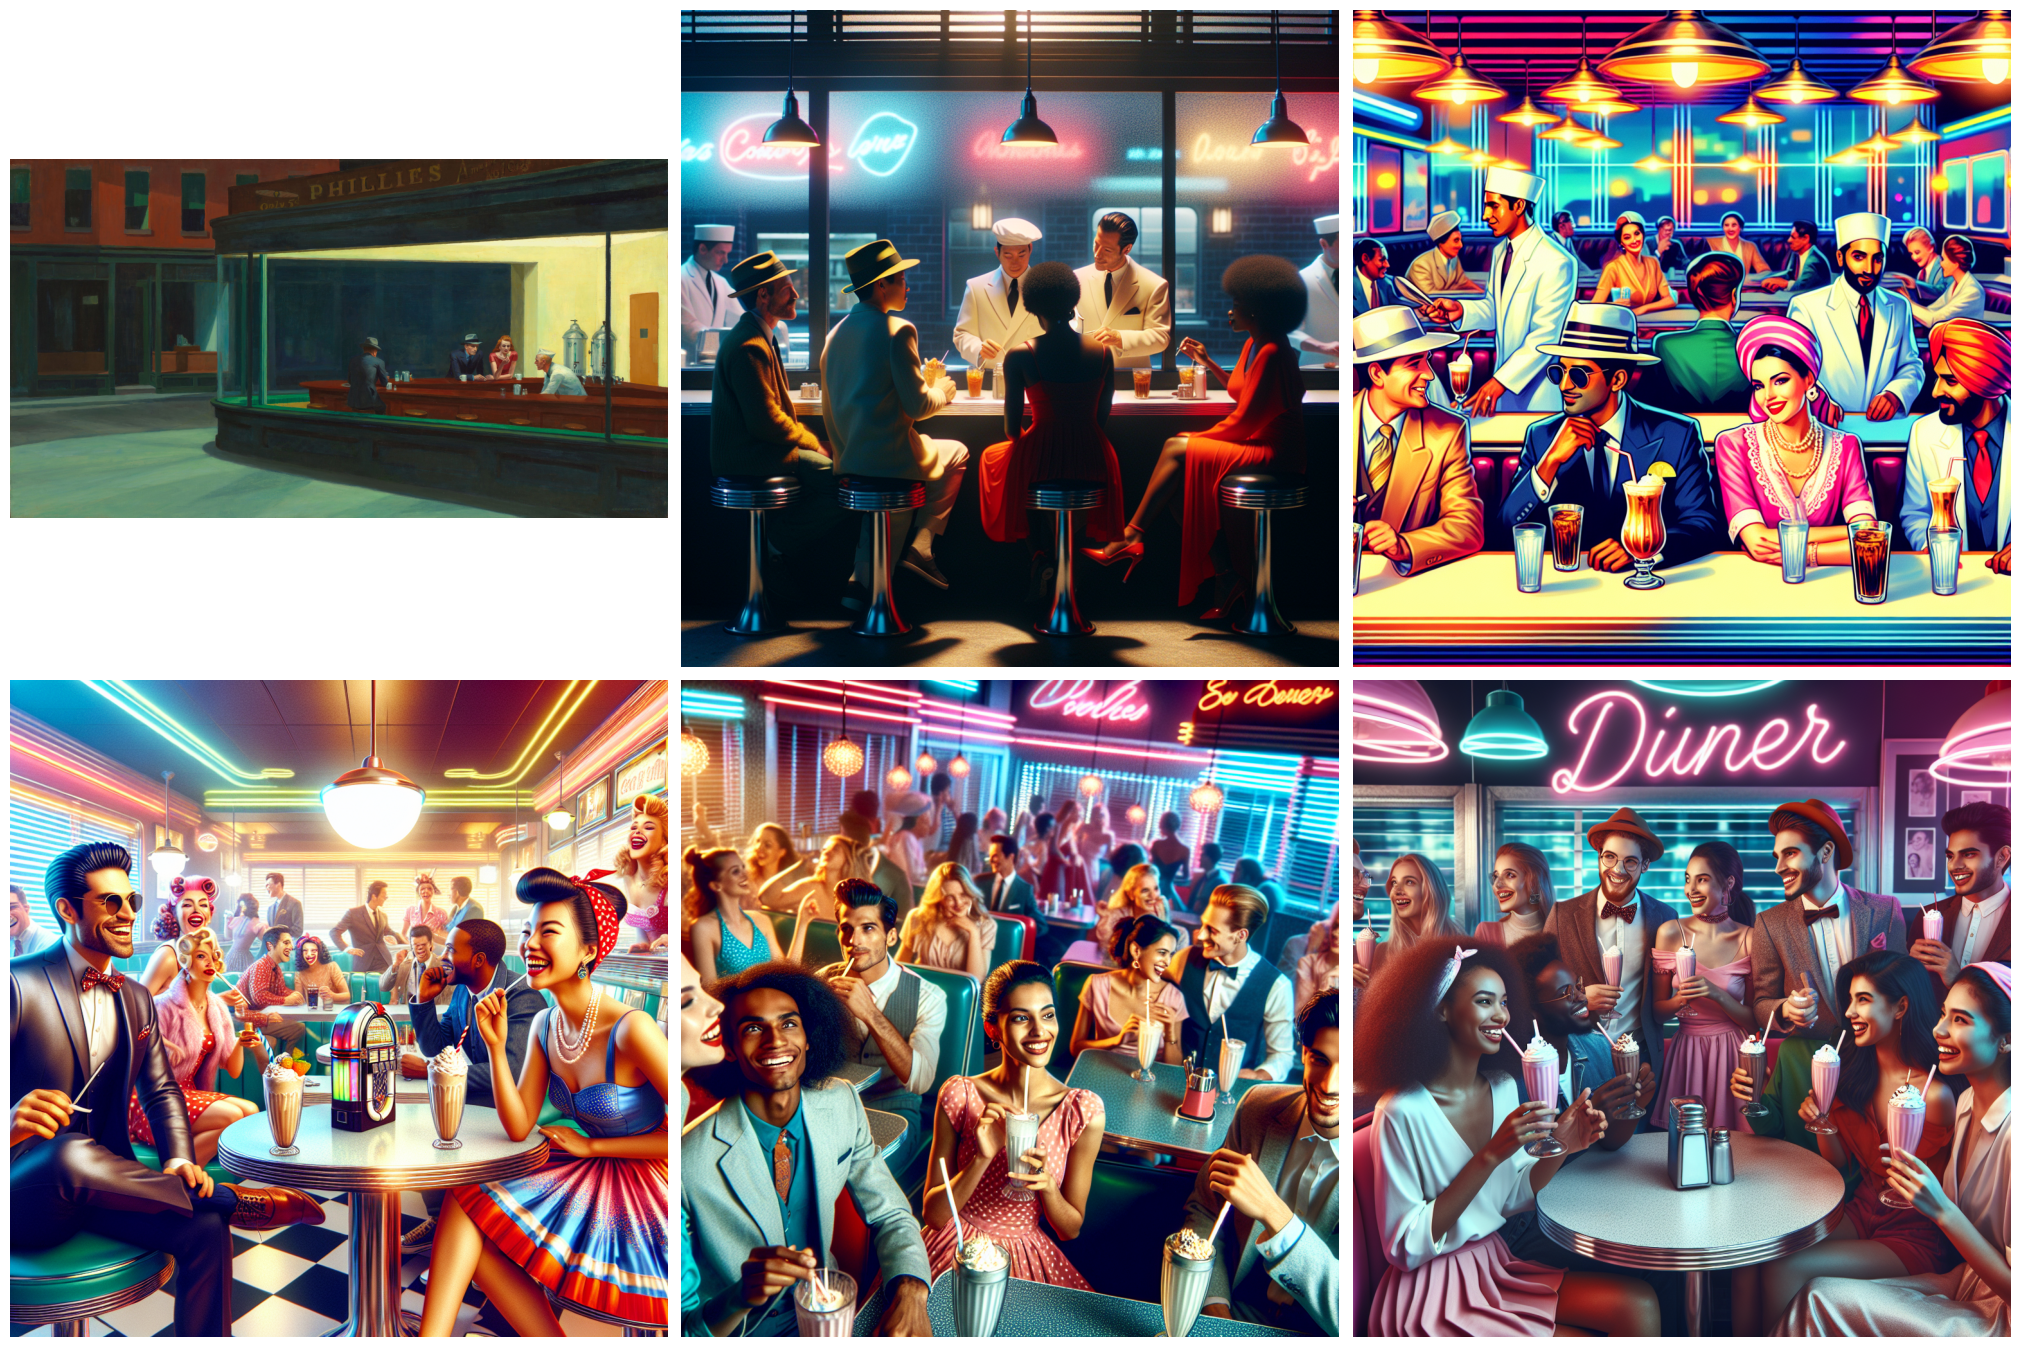

In [16]:
num_images = len(all_urls)
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
  
# Calculate the number of rows and columns for the grid
cols = math.ceil(math.sqrt(num_images))
rows = math.ceil(num_images / cols)

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()
# Loop through the image URLs and display each image
for ax, url in zip(axes, all_urls):
    response = requests.get(url,headers=headers)
    img = PILImage.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off') 

# Hide any unused subplots
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout(pad=0, h_pad=-30, w_pad=1, rect=None)

plt.savefig(f'grids/output_grid_{name}.png', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()


Using each image a gif is created. This is set to a default 512x512 size. 

In [18]:
# Desired size for all images
desired_size = (512, 512)  # Width, Height
speed = 2 # How many seconds each frame appears

# Fetch images, resize them, and store them in a list
images = []
for url in all_urls:
    response = requests.get(url,headers=headers)
    img = PILImage.open(BytesIO(response.content))
    img = img.resize(desired_size, PILImage.LANCZOS)  # Resize image
    images.append(img)

# Convert images to a GIF
gif_path = f'gifs/output_{name}.gif'
imageio.mimsave(gif_path, images, format='GIF', loop=0,fps=1/speed)

print(f"GIF saved at {gif_path}")

GIF saved at gifs/output_nighthawks.gif


Now we should have the final product of a gif showing each round.

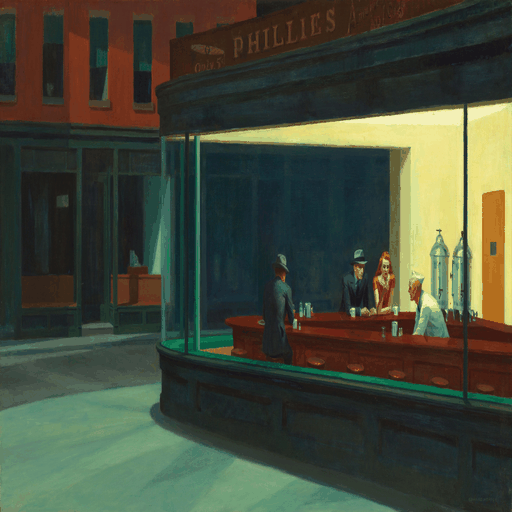

'The scene depicts a diner at night with four patrons at the bar: two men in hats, a woman in red, and a white-suited server.'

'A retro diner scene with stylish patrons in hats and elegant dresses, enjoying drinks. White-suited servers attend them amid neon lights.'

'A vibrant retro diner scene, showcasing stylishly dressed patrons enjoying drinks. Bright lights and diverse characters create a lively atmosphere.'

'A vibrant retro diner scene features stylishly dressed couples enjoying milkshakes, laughing, and dancing under colorful neon lights.'

'A vibrant retro diner scene filled with stylishly dressed young people enjoying milkshakes. Neon lights illuminate cheerful interactions.'

'A lively diner scene filled with diverse friends enjoying milkshakes. Neon lights illuminate their joyous faces, capturing a nostalgic vibe.'

In [19]:
clear_output(wait=True)
display(Image(filename=gif_path))

for description in all_descriptions:
    display(description)
    time.sleep(speed)  # Delay in seconds

